In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, LSTM
import tensorflow as tf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import train_test_split
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import STL

from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import statsmodels.api as sm
from scipy.stats import chi2
import statistics

from sklearn.metrics import accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats
from scipy.signal import dlsim
from statsmodels.tsa.arima.model import ARIMA

## LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

sns.set(style="darkgrid")

2023-05-12 07:57:04.051986: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/samueljon/opt/anaconda3/envs/cs5525/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Supporting Functions

In [2]:
########################################
# Via Lab 1
def ADF_Cal(x, conf=0.05):
    result = adfuller(x)
    print('p-value: %f' % result[1]) 
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print(f'Series is {"not " if result[1] >= conf else ""}stationary')

def kpss_test(timeseries, conf=0.05):
    print ('Results of KPSS Test:')
    statistic, p_value, n_lags, critical_values = kpss(timeseries, regression='c', nlags="auto")
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'\t{key} : {value}')
    print(f'Series is {"not " if p_value < conf else ""}stationary')
    
def getRollingMeanVar(df, rnd=2):
    newDf = df.copy()
    for col in newDf.select_dtypes(include=np.number).columns:
        for row in range(len(newDf)):
            newDf.at[row, col+'_rollingMean']=newDf.iloc[0:row+1][col].mean()
            newDf.at[row, col+'_rollingVar']=newDf.iloc[0:row+1][col].var()
    newDf.loc[:, newDf.filter(regex='rolling').columns] = newDf.filter(regex='rolling').fillna(0.0)
    newDf.loc[:, newDf.filter(regex='rolling').columns] =  newDf.filter(regex='rolling').round(rnd)
    return newDf

def getRollingMeanVarPlot(df, x_label="",label=""):
    if label != x_label:
        fig, (ax1, ax2) = plt.subplots(2, 1, sharey=False, figsize=(10, 10))
        if x_label=="":
            ax1.plot(range(len(df)), df[label+'_rollingMean'])
            ax1.set_title(f'Rolling Mean for {label}')
            ax1.set_ylabel("Magnitude")
            ax2.plot(range(len(df)), df[label+'_rollingVar'])
            ax2.set_title(f'Rolling Variance for {label}')
            ax2.set_ylabel("Magnitude")
            plt.xlabel("Samples")
            plt.show()
        else:
            ax1.plot(df[x_label], df[label+'_rollingMean'])
            ax1.set_title(f'Rolling Mean for {label}')
            ax1.set_ylabel("Magnitude")
            ax2.plot(df[x_label], df[label+'_rollingVar'])
            ax2.set_title(f'Rolling Variance for {label}')
            ax2.set_ylabel("Magnitude")
            plt.xlabel("Samples")
            plt.show()
    
########################################
# Via Lab 2

def getACFSingle(data, timeLag=0):
    """
    :data - numpy array
    :timeLag - t2-t1
    :return - Autocorrelation value [-1,1]
    """
    mean = np.mean(data)
    return np.sum((data[timeLag:]-mean)*(data[:len(data[timeLag:])]-mean))/np.sum(np.square(data - mean))
    
def getACFAll(data, timeLagMax=10, title="White Noise", plot = False, soloPlot=True):
    """
    :data - numpy array
    :timeLagMax - maximum time lag wish to calcualte. Will calculate all time lag from 0 to timeLagMax
    :return data - Autocorrelation value for timeLag in [0:timeLagMax]
    """
    returnData = []
    for timeLag in range(timeLagMax+1):
        returnData.append(getACFSingle(data,timeLag))
    returnDataX = list(range(-timeLagMax,0))+list(range(timeLagMax+1))
    returnDataY = returnData[::-1]+returnData[1:]
    if plot:
        if soloPlot:
            fig = plt.figure(figsize=(7,7))
        ci = 1.96/np.sqrt(len(data))
        plt.stem(returnDataX,returnDataY, markerfmt="or", basefmt="black",linefmt="C0-")
        plt.fill_between(returnDataX, len(returnDataX)*[-ci], len(returnDataX)*[ci], color='b', alpha=.1)
        plt.xlabel("Lags")
        plt.ylabel("Magnitude")
        plt.title("Autocorrelation Function of "+title)
    return returnDataX, returnDataY


########################################
# Via HW 2
def trainAvgMethod(train, test):
    predTrain = [0]
    for idx in range(len(train)):
        predTrain = predTrain + [round(sum(train[:idx+1])/(idx+1),1)]
    predTest = predTrain.pop(-1)
    return predTrain, len(test)*[predTest]

def trainNaiveMethod(train,test):
    predTrain = [0] + train[:-1]
    predTest = len(test)* [train[-1]]
    return predTrain, predTest
    
def trainDriftMethod(train,test):
    predTrain = [0,0]
    predTest = []
    for idx in range(2,len(train)):
        m = (train[idx-1]-train[0])/(idx-1)
        predTrain = predTrain + [train[idx-1]+m]
    m = (train[-1]-train[0])/len(train)
    for idx in range(len(test)):
        predTest = predTest + [train[-1]+(idx+1)*m]
    return predTrain, predTest

def getError(act, pred, offset=0):
    error = [round(a-b,1) for a, b in zip(act, pred)][offset:]
    return error, [round(x**2,1) for x in error]

def getMSE(errorSq,offset = 1):
    return round(sum(errorSq[offset:])/len(errorSq[offset:]),2)

def getMethodDF(train, test, offsetDF=1, method="Average"):
    if method=="Average":
        predTrain, predTest = trainAvgMethod(train, test)
    elif method=="Naive":
        predTrain, predTest = trainNaiveMethod(train, test)
    elif method=="Drift":
        predTrain, predTest = trainDriftMethod(train, test)
    
    errorTrain, errorTrainSq = getError(train, predTrain, offset=offsetDF)
    errorTest, errorTestSq = getError(test, predTest, offset=0)
    predTrain[:offsetDF]=offsetDF*[None]
    trainDF = pd.DataFrame({'actual': train, 'predicted': predTrain, "error":offsetDF*[None]+errorTrain, "errorSq":offsetDF*[None]+errorTrainSq}, index=range(1,len(train)+1))
    testDF= pd.DataFrame({'actual': test, 'predicted': predTest, "error":errorTest, "errorSq":errorTestSq}, index=range(len(train)+1,len(train)+len(test)+1))
    return trainDF, testDF

def getGraph(dfTrain, dfTest, name="Average"):
    fig = plt.figure(figsize=(12,8))
    ## To connect train and test
        #plt.plot(list(dfTrain.index)+[len(dfTrain)+1], list(dfTrain.actual)+[dfTest.actual.iloc[0]], marker="o",label="Train Set")
    plt.plot(list(dfTrain.index), list(dfTrain.actual),label="Train Set")
    plt.plot(dfTest.index, dfTest.actual,label="Test Set")
    plt.plot(dfTest.index,dfTest.predicted,label="Predicted H-Step")
    plt.xlabel("Time")
    plt.ylabel("Dependent Variable")
    plt.title(name+" Method Prediction for Data")
    plt.grid()
    plt.legend()
    plt.show()

########################################
# Via Lab 5

def getPhiJKK(acf, j, k):
    assert(k<=len(acf))
    assert(j<=len(acf))
    assert((j+k)<=len(acf))
    acf = np.concatenate((acf[::-1],acf[1:]))
    mid = len(acf)//2
    pacfNum = []
    pacfDen = []
    for row in range(k):
        pacfNum.append(np.append(acf[mid+j+row:mid+j+row-k+1:-1],acf[mid+j+row+1]))
        pacfDen.append(np.append(acf[mid+j+row:mid+j+row-k+1:-1],acf[mid+j-k+row+1]))
    pacfNum = np.vstack(pacfNum)
    pacfDen = np.vstack(pacfDen)
#     return pacfNum, pacfDen
    ret = np.linalg.det(pacfNum)/np.linalg.det(pacfDen)
    return round(ret,2) if ret!=np.nan else np.nan


def getGPAC(acf, maxJ=7, maxK=7, plot=True):
    gpac = []
    for j in range(maxJ):
        row = []
        for k in range(1,maxK+1):
            row.append(getPhiJKK(acf,j,k))
        gpac.append(row)
    gpac = pd.DataFrame(gpac, columns=list(range(1,maxK+1)))
    if plot:    
        fig = plt.figure(figsize=(12,8))
        sns.heatmap(gpac, annot=True)
        plt.title("Generalized Partial Autocorrelation (GPAC) Table")
        plt.xlabel("n_a")
        plt.ylabel("n_b")
        plt.show()
    return gpac

########################################
# Via HW 5

def ACF_PACF_Plot(y,lags):
    acf = sm.tsa.stattools.acf(y, nlags=lags) 
    pacf = sm.tsa.stattools.pacf(y, nlags=lags) 
    fig = plt.figure(figsize=(12,8))
    plt.subplot(211)
    plt.title('ACF/PACF of the raw data') 
    plot_acf(y, ax=plt.gca(), lags=lags) 
    plt.subplot(212)
    plot_pacf(y, ax=plt.gca(), lags=lags)
    fig.tight_layout(pad=3)
    plt.show()
    
def arma_lma(y, ar_order, ma_order, delta=1e-6, max_iter=100, 
             tol=1e-3, lambda_init=1e-2, lambda_factor=10, lambda_max = 1e9):
    ### HELPER FUNCTIONS
    def getDLSIMParams(params):
        """
        Note that this is to solve for eT rather than yT hence the ordering of the 
        ar and ma coefficients are reversed
        """
        a = np.hstack((1, params[:ar_order])) ## ar
        b = np.hstack((1, params[ar_order:])) ## ma 
        if ma_order < ar_order:
            b = np.append(b, np.array((ar_order-ma_order)*[0]))
        if ma_order > ar_order:
            a = np.append(a, np.array((ma_order-ar_order)*[0]))     
        return (a,b,1)
    
    residual_fun = lambda params: dlsim(getDLSIMParams(params), y.squeeze())[1]
    SSE_fun = lambda e: (e.T @ e).squeeze()

    ## INITIALIZATION
    var = 0
    cov = 0 
    params = np.zeros(ar_order+ma_order)
    res = y.copy()
    SSE = SSE_fun(res).item()   
    lambda_val = lambda_init
    X = np.zeros((len(y),len(params)))
    SSE_graph = [SSE]
    error = ""
    # PERFORM Levenberg-Marquardt
    for i in range(max_iter):
        
        # CALCULATE X
        for j in range(len(params)):
            params_pert = params.copy()
            params_pert[j] += delta
            X[:, j] = ((res - residual_fun(params_pert)) / delta).squeeze()
        
        # CALCULATE A, g, DeltaTheta (dp)
        A = X.T @ X
        g = X.T @ res 
        A += lambda_val * np.identity(len(A))
        dp = np.linalg.inv(A) @ g


        # UPDATE PARAMETERS
        params = params + dp.squeeze()
        res = residual_fun(params)
        SSE_new = SSE_fun(params)
        SSE_graph.append(SSE_new)
        
        # CONVERGENCE CHECK
        if SSE_new < SSE:
            if np.linalg.norm(dp) < tol:
                var = SSE_new/(X.shape[1]-X.shape[0])
                cov = (var*np.linalg.inv(A)).squeeze()
                break    
            lambda_val /= lambda_factor
        else:
            lambda_val *= lambda_factor
            if lambda_val > lambda_max:
                print("ERROR BROKE LAMBDA_MAX")
                error = "ERROR BROKE LAMBDA_MAX"
                break
        SSE = SSE_new
    if i == max_iter:
        print("ERROR PASS ITERATION")
        error = "ERROR PASS ITERATION"
    return params, var, cov, SSE_graph, error


In [722]:
f = pd.read_csv("Occupancy_Estimation.csv", delimiter=',', skipinitialspace = True)
f.columns = f.columns.str.replace(' ', '') 
f['time'] = pd.to_datetime(f['Date'] + ' ' + f['Time'], format='%Y/%m/%d %H:%M:%S')
f.drop(columns=['Date','Time'], inplace = True)

In [727]:
set(f['time'].dt.day)

{10, 11, 22, 23, 24, 25, 26}

# Data Exploratory & Cleaning

In [3]:
df = pd.read_csv("Occupancy_Estimation.csv", delimiter=',', skipinitialspace = True)
df.columns = df.columns.str.replace(' ', '') 
print(df.shape)
df['time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%Y/%m/%d %H:%M:%S')
df.drop(columns=['Date','Time'], inplace = True)
df = df[df['time'].dt.month == 12]
df = df[df['time'].dt.day.isin([22,23,24])]
df = df[['time']+list(df.columns)[:-1]]
df['time'] = pd.date_range("2017-12-22 10:49:41", freq="30S", periods=len(df))

print("The shape of the December ONLY data is (row, column):", str(df.shape))

(10129, 19)
The shape of the December ONLY data is (row, column): (5305, 18)


In [701]:
df.describe()

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
count,5305.000000,5305.000000,5305.000000,5305.000000,5305.000000,5305.000000,5305.000000,5305.000000,5305.000000,5305.000000,5305.000000,5305.000000,5305.000000,5305.000000,5305.000000,5305.000000,5305.000000
mean,25.569955,25.717084,25.130224,25.855016,42.912912,41.822809,50.087276,15.815269,0.235361,0.161957,0.233676,0.110566,530.495759,-0.006553,0.137418,0.113289,0.612253
std,0.412754,0.728116,0.493852,0.359521,62.419314,83.962010,71.551968,21.233240,0.408521,0.335159,0.551491,0.164515,237.410139,1.480286,0.344320,0.316976,1.020843
min,24.940000,24.750000,24.440000,25.130000,0.000000,0.000000,0.000000,0.000000,0.060000,0.040000,0.050000,0.050000,355.000000,-6.296154,0.000000,0.000000,0.000000
25%,25.190000,25.190000,24.690000,25.560000,0.000000,0.000000,0.000000,0.000000,0.070000,0.050000,0.060000,0.060000,360.000000,-0.161538,0.000000,0.000000,0.000000
50%,25.440000,25.440000,25.000000,25.750000,0.000000,0.000000,6.000000,4.000000,0.070000,0.050000,0.060000,0.060000,380.000000,0.000000,0.000000,0.000000,0.000000
75%,25.940000,25.940000,25.560000,26.250000,117.000000,24.000000,71.000000,26.000000,0.120000,0.080000,0.090000,0.070000,645.000000,0.242308,0.000000,0.000000,1.000000
max,26.380000,29.000000,26.190000,26.560000,165.000000,258.000000,280.000000,74.000000,3.880000,3.440000,3.670000,3.400000,1270.000000,8.980769,1.000000,1.000000,3.000000


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5305 entries, 0 to 5304
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   time                  5305 non-null   datetime64[ns]
 1   S1_Temp               5305 non-null   float64       
 2   S2_Temp               5305 non-null   float64       
 3   S3_Temp               5305 non-null   float64       
 4   S4_Temp               5305 non-null   float64       
 5   S1_Light              5305 non-null   int64         
 6   S2_Light              5305 non-null   int64         
 7   S3_Light              5305 non-null   int64         
 8   S4_Light              5305 non-null   int64         
 9   S1_Sound              5305 non-null   float64       
 10  S2_Sound              5305 non-null   float64       
 11  S3_Sound              5305 non-null   float64       
 12  S4_Sound              5305 non-null   float64       
 13  S5_CO2            

array([[<AxesSubplot:title={'center':'S1_Temp'}>,
        <AxesSubplot:title={'center':'S2_Temp'}>,
        <AxesSubplot:title={'center':'S3_Temp'}>,
        <AxesSubplot:title={'center':'S4_Temp'}>],
       [<AxesSubplot:title={'center':'S1_Light'}>,
        <AxesSubplot:title={'center':'S2_Light'}>,
        <AxesSubplot:title={'center':'S3_Light'}>,
        <AxesSubplot:title={'center':'S4_Light'}>],
       [<AxesSubplot:title={'center':'S1_Sound'}>,
        <AxesSubplot:title={'center':'S2_Sound'}>,
        <AxesSubplot:title={'center':'S3_Sound'}>,
        <AxesSubplot:title={'center':'S4_Sound'}>],
       [<AxesSubplot:title={'center':'S5_CO2'}>,
        <AxesSubplot:title={'center':'S5_CO2_Slope'}>,
        <AxesSubplot:title={'center':'S6_PIR'}>,
        <AxesSubplot:title={'center':'S7_PIR'}>],
       [<AxesSubplot:title={'center':'Room_Occupancy_Count'}>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

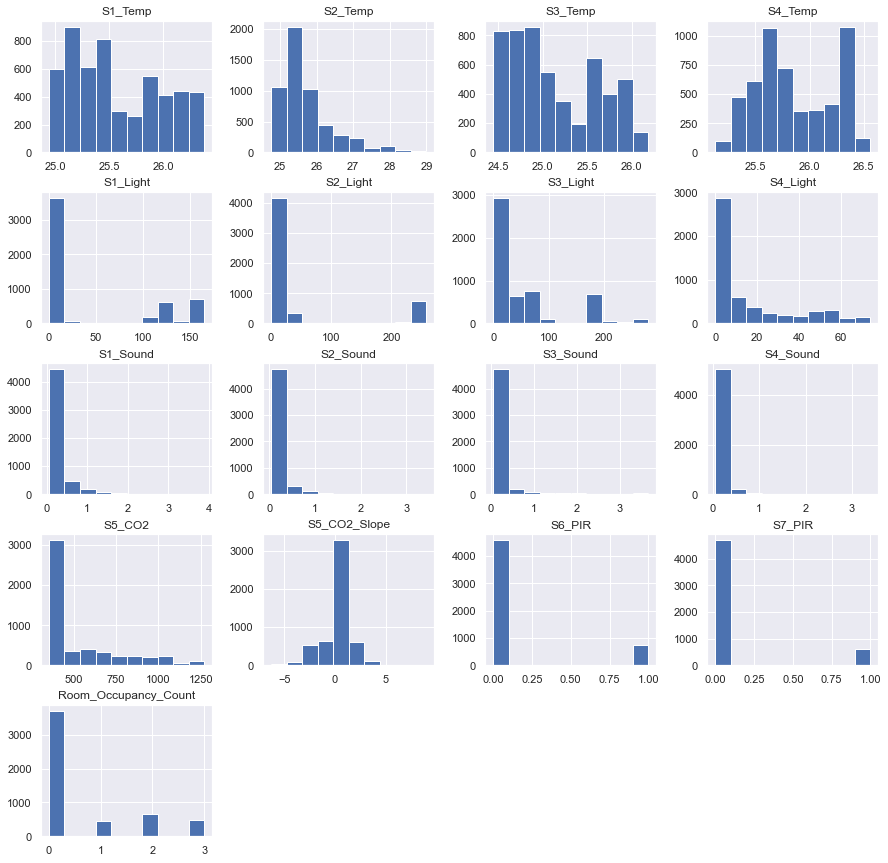

In [339]:
df.drop(columns=['time'],axis=1).hist(figsize=(15,15))

Text(0.5, 1.0, 'Time Series for Room Occupancy Count')

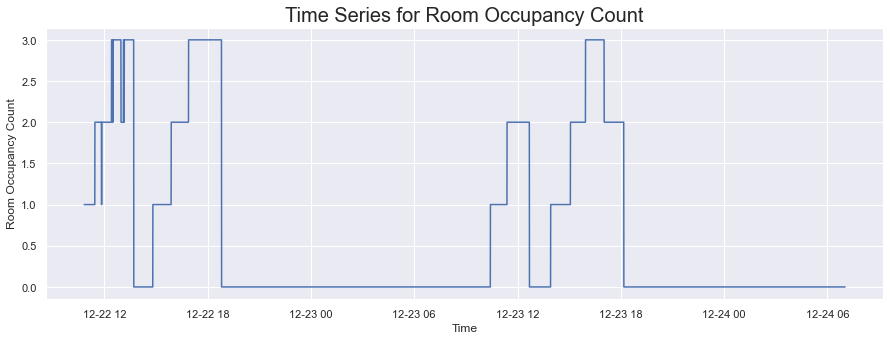

In [340]:
plt.figure(figsize=(15,5))
plt.plot(df.time.values, df.Room_Occupancy_Count.values)
plt.xlabel('Time')
plt.ylabel('Room Occupancy Count')
plt.title('Time Series for Room Occupancy Count', fontsize=20)

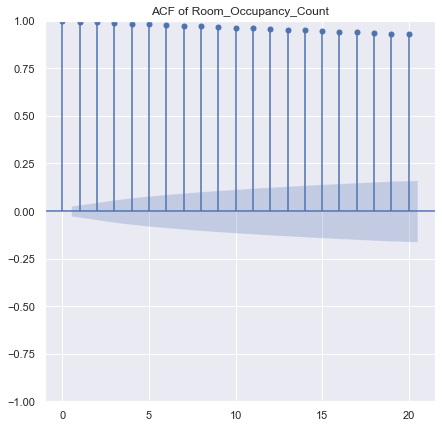

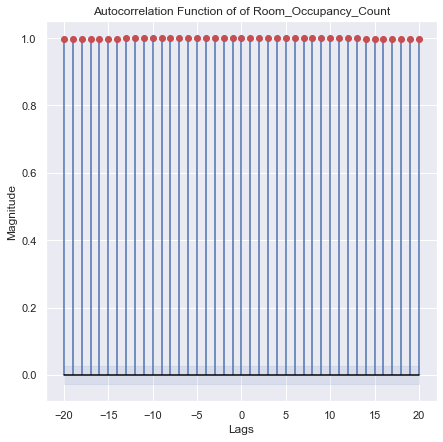

/Users/samueljon/opt/anaconda3/envs/cs5525/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


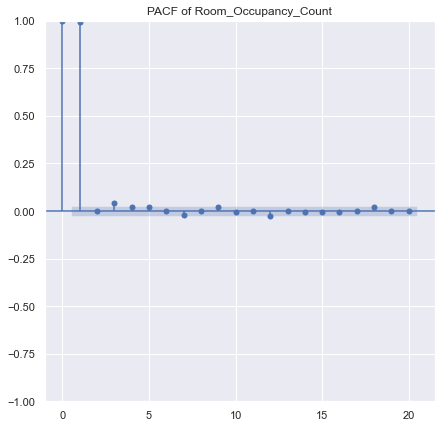

In [4]:
## ACF and PACF
curr_fig, curr_ax = plt.subplots(figsize=(7, 7))
plot_acf(df.Room_Occupancy_Count.values, lags=20, ax=curr_ax, title="ACF of Room_Occupancy_Count")
plt.show()

getACFAll(df.Room_Occupancy_Count, timeLagMax=20, title="of Room_Occupancy_Count", plot = True, soloPlot=True)
plt.show()

curr_fig, curr_ax = plt.subplots(figsize=(7, 7))
plot_pacf(df.Room_Occupancy_Count.values, lags=20, ax=curr_ax, title="PACF of Room_Occupancy_Count")
plt.show()

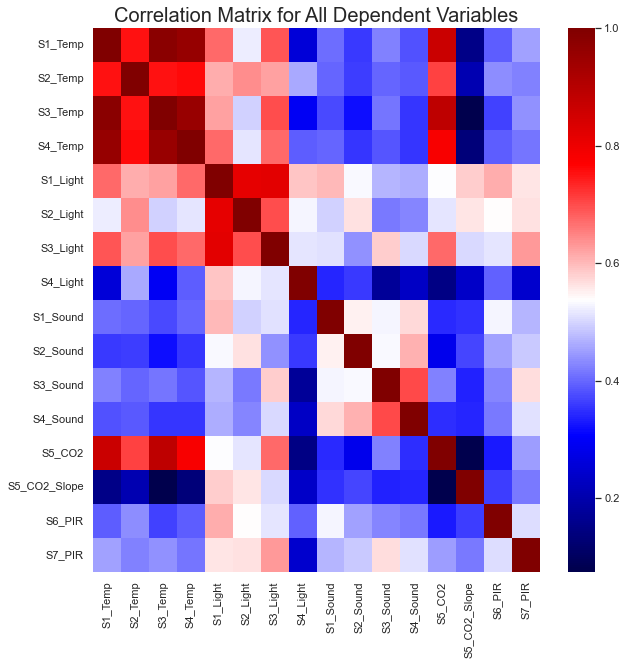

In [712]:
## Correlation Map
plt.figure(figsize=(10,10))
sns.heatmap(df.drop(['Room_Occupancy_Count'], axis=1).corr(method='pearson'), annot=False, cmap="seismic")
plt.title(f"Correlation Matrix for All Dependent Variables",  fontsize=20)
plt.show()

In [5]:
## Split data

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], test_size=0.2, random_state=17, shuffle=False)
dfY_train = pd.DataFrame({"time":X_train['time'], "Room_Occupancy_Count":y_train})
dfY_test = pd.DataFrame({"time":X_test['time'], "Room_Occupancy_Count":y_test})

print(f"Total Training Entires: {X_train.values.shape[0]}")
print(f"Total Test Entires: {X_test.values.shape[0]}")


Total Training Entires: 4244
Total Test Entires: 1061


ADF Test for Dependent Variable
p-value: 0.043495
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Series is stationary


KPSS Test for Dependent Variable
Results of KPSS Test:
KPSS Statistic: 1.0699858109253737
p-value: 0.01
num lags: 40
Critical Values:
	10% : 0.347
	5% : 0.463
	2.5% : 0.574
	1% : 0.739
Series is not stationary


/Users/samueljon/opt/anaconda3/envs/cs5525/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


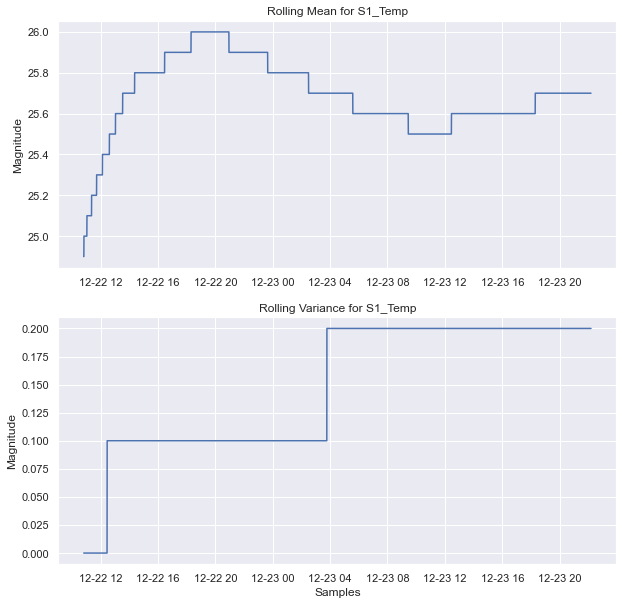

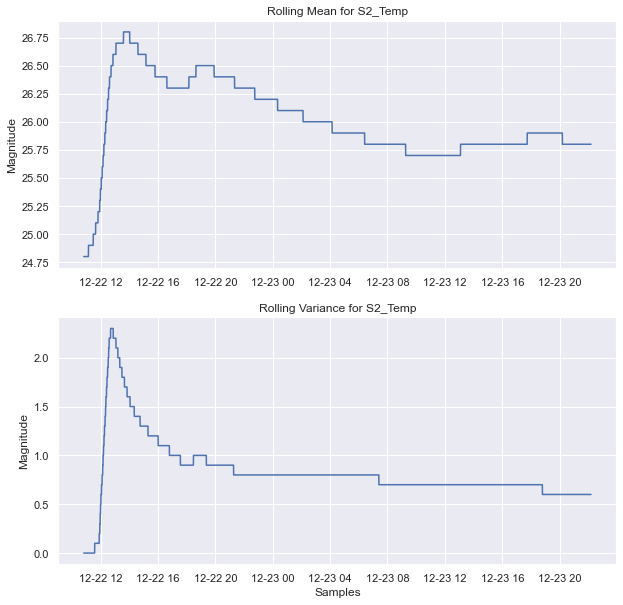

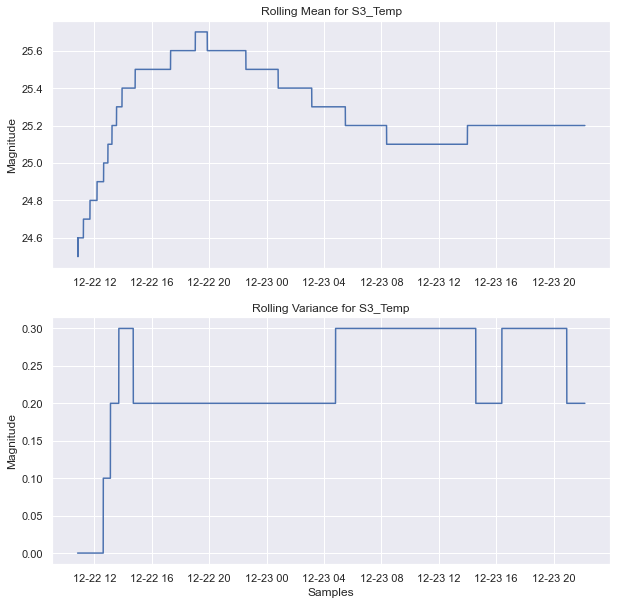

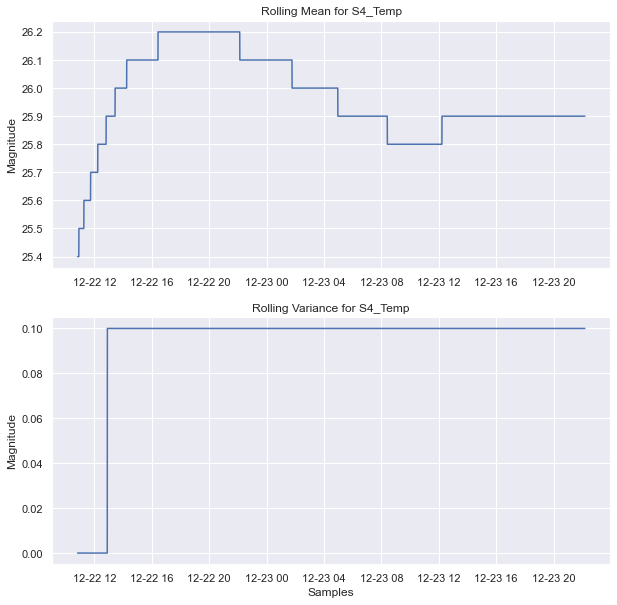

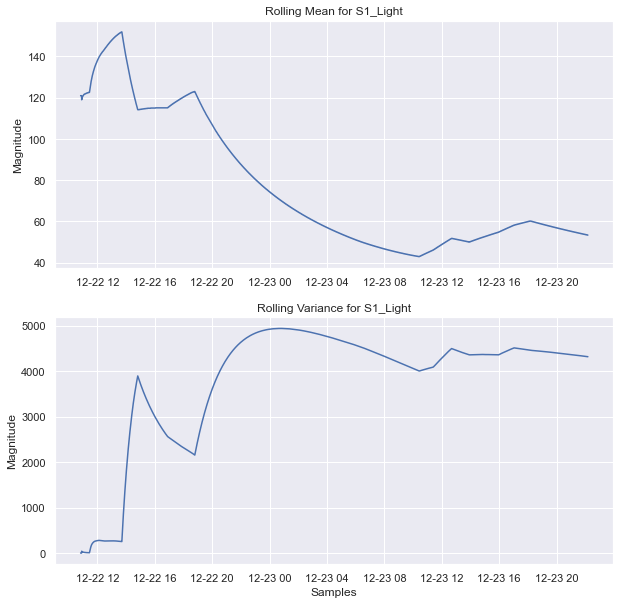

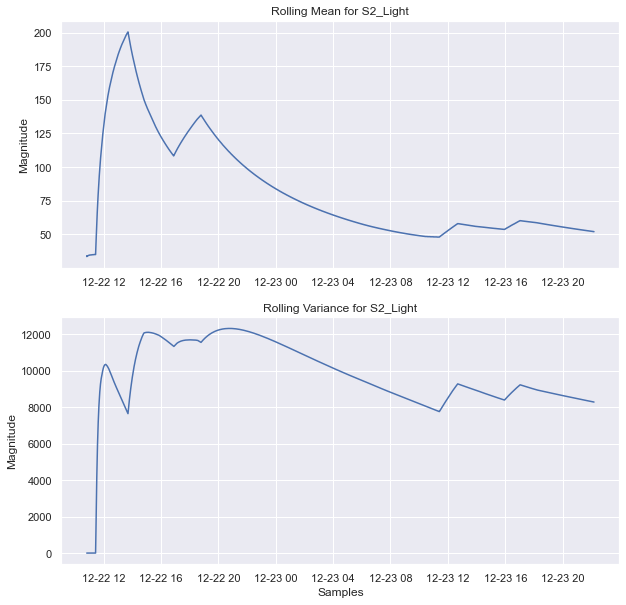

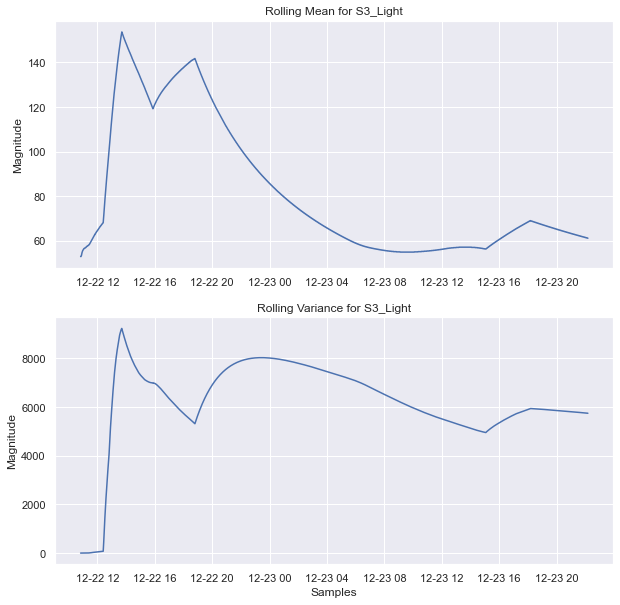

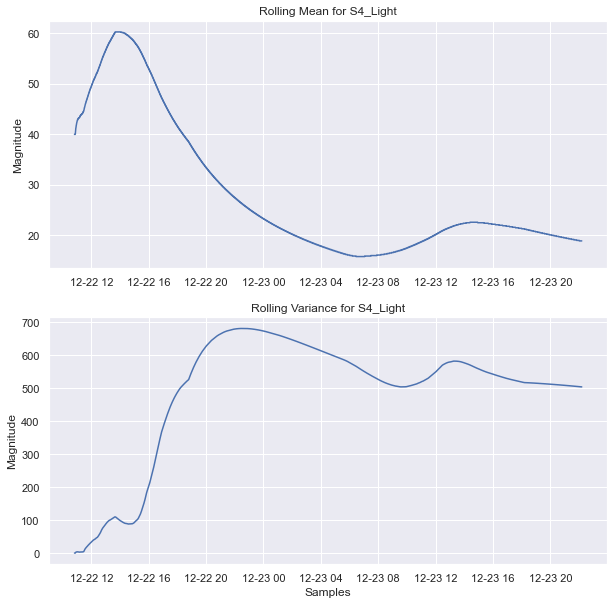

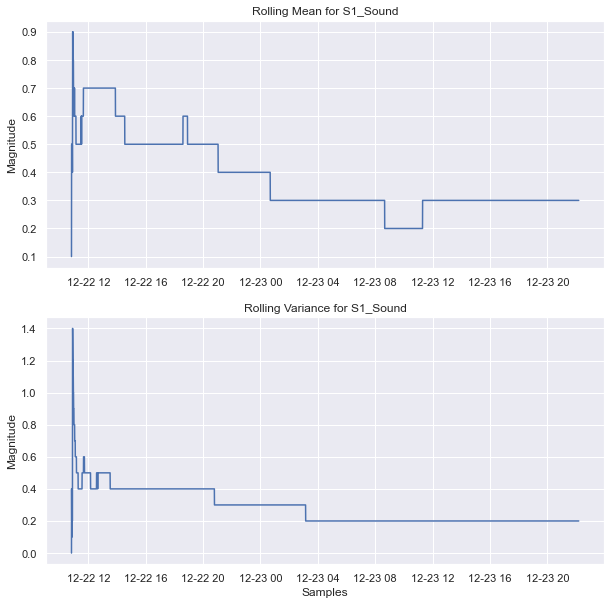

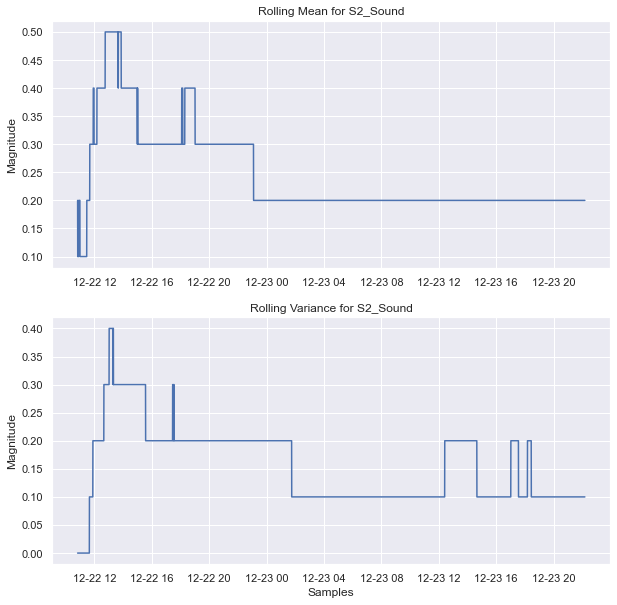

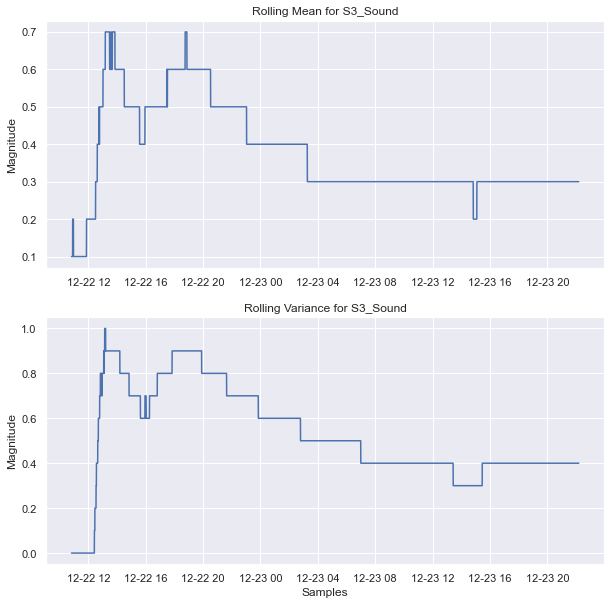

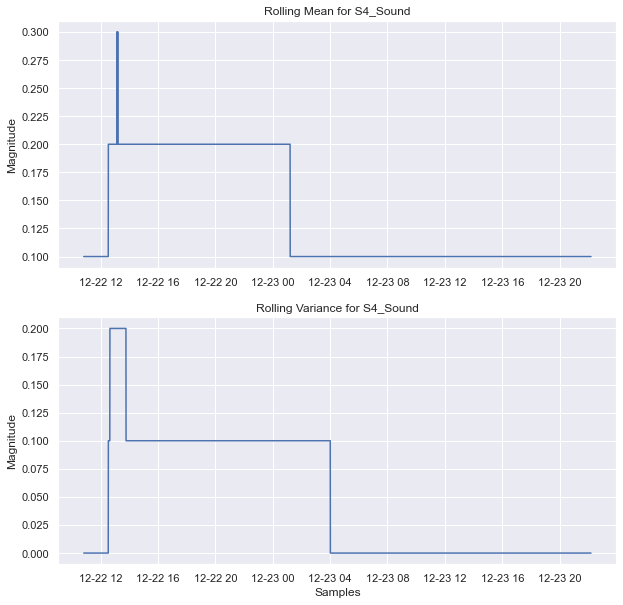

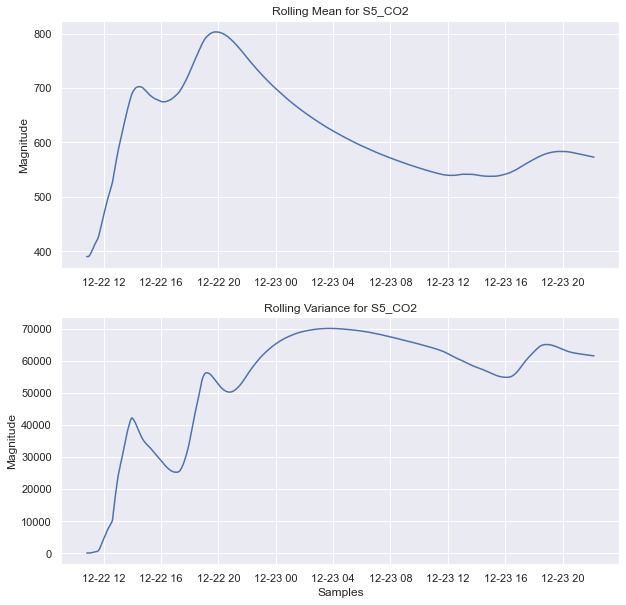

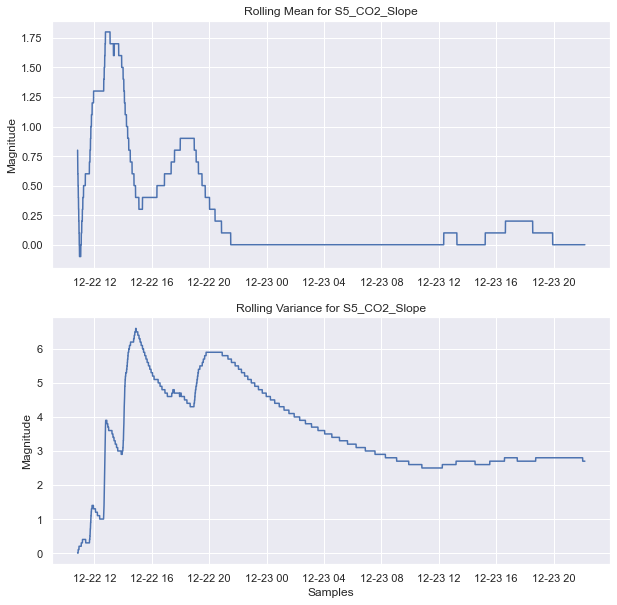

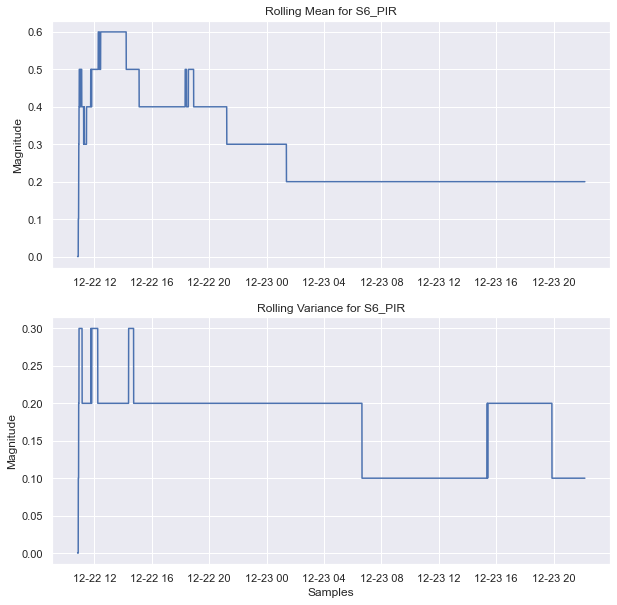

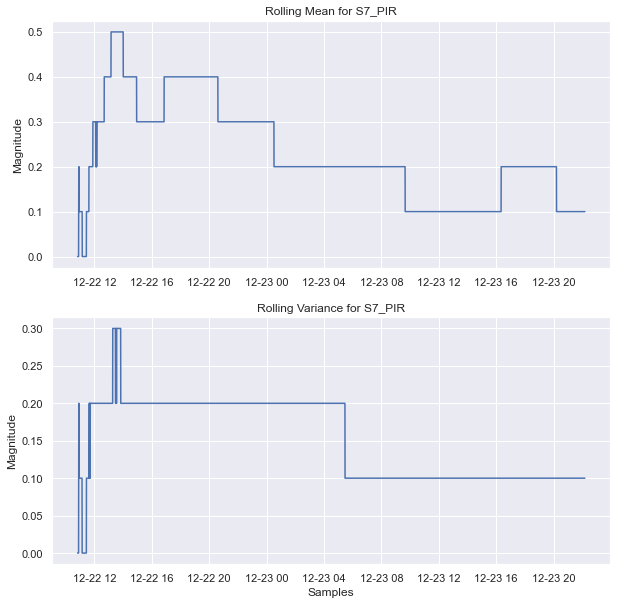

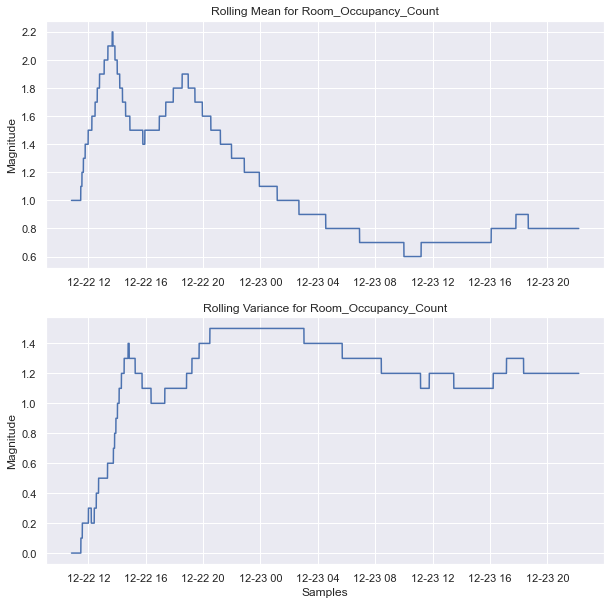

In [6]:
## Stationality

## ADF and KPSS
print("ADF Test for Dependent Variable")
ADF_Cal(y_train, conf=0.05)
print("\n")
print("KPSS Test for Dependent Variable")
kpss_test(y_train, conf=0.05)

## Rolling Average and Variance of Independent
dfRolling = getRollingMeanVar(X_train, rnd=1)
for label in X_train.columns:
    getRollingMeanVarPlot(dfRolling, x_label="time", label=label)
    
## Rolling Average and Variance of Dependent
getRollingMeanVarPlot(getRollingMeanVar(dfY_train, rnd=1), x_label="time", label="Room_Occupancy_Count")

## If needed, 1st order differencing. Don't think required
# dfY_train['Room_Occupancy_Count_1stDiff'] = dfY_train['Room_Occupancy_Count'].diff()
# getRollingMeanVarPlot(getRollingMeanVar(dfY_train[["time","Room_Occupancy_Count_1stDiff"]], rnd=3), x_label="time", label="Room_Occupancy_Count_1stDiff")

X_train = X_train.set_index("time")
X_test = X_test.set_index("time")
dfY_train = dfY_train.set_index("time")
dfY_test = dfY_test.set_index("time")

/var/folders/lg/9fhjsjp14vz2kyr4qqk41t7m0000gn/T/ipykernel_19832/930400820.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  dfY_STL.plot().show()


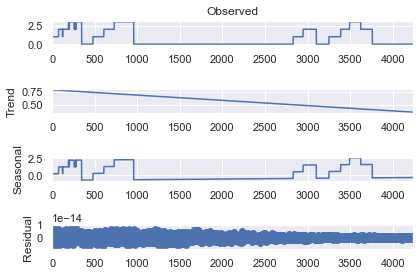

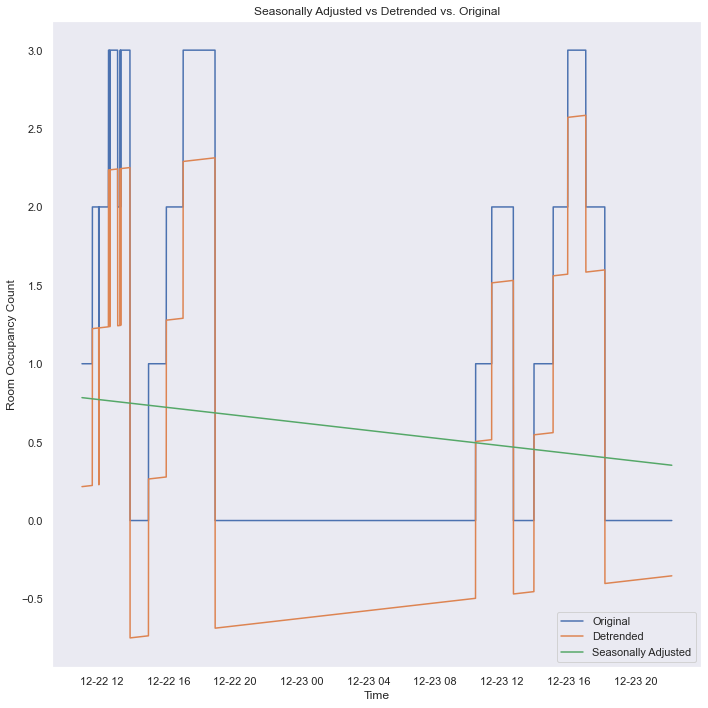

The strength of trend for this data set is ~100.00%
The strength of seasonality for this data set is ~100.00%


In [7]:
## Time Series Decomposition
## Via HW3 

## Plot decomposed components
dfY_STL = STL(dfY_train['Room_Occupancy_Count'].values,  period=2*60*24).fit()
dfY_STL.plot().show()

## Plot detrended and seasonally adjusted
fig = plt.figure(figsize=(10,10))
plt.plot(dfY_train.index, dfY_train.Room_Occupancy_Count,label="Original")
plt.plot(dfY_train.index, (dfY_STL.resid + dfY_STL.seasonal),label=f"Detrended")
plt.plot(dfY_train.index, (dfY_STL.resid + dfY_STL.trend),label=f"Seasonally Adjusted")
plt.xlabel("Time")
plt.ylabel("Room Occupancy Count")
plt.title(f"Seasonally Adjusted vs Detrended vs. Original")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## State trend and seasonal strength
Ft = np.maximum(0 ,1 - dfY_STL.resid.var()/(dfY_STL.resid+ dfY_STL.trend).var()) 
print(f'The strength of trend for this data set is ~{Ft*100:.2f}%')

Fs= np.maximum(0 ,1 - dfY_STL.resid.var()/(dfY_STL.resid+dfY_STL.seasonal).var()) 
print(f'The strength of seasonality for this data set is ~{Fs*100:.2f}%')

# Modeling

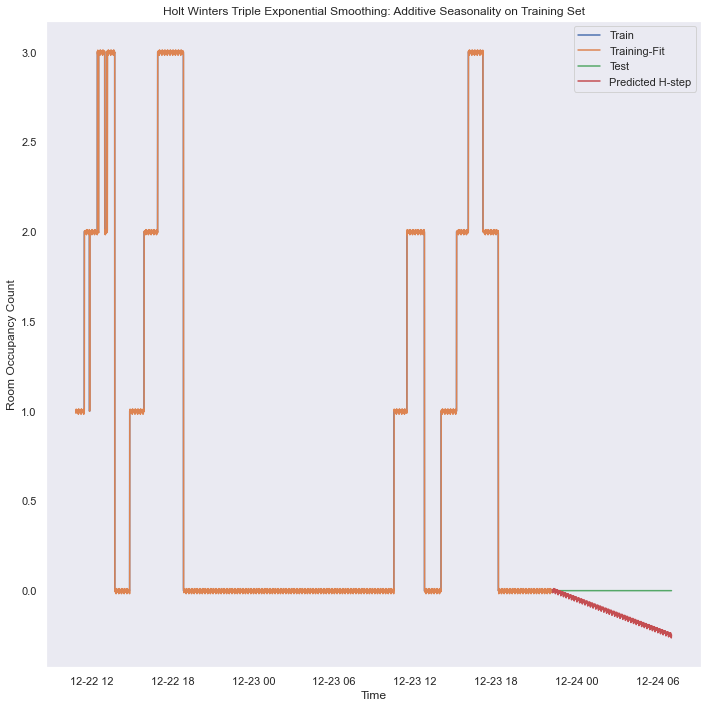

In [8]:
## Holt-Winters Model -- Additive Method
HWES3_ADD = ExponentialSmoothing(dfY_train["Room_Occupancy_Count"].values,trend='add',seasonal='add',seasonal_periods=24).fit()
dfY_train['HWES3_ADD'] = HWES3_ADD.fittedvalues
dfY_test['HWES3_ADD'] = HWES3_ADD.forecast(len(dfY_test))

fig = plt.figure(figsize=(10,10))
plt.plot(dfY_train.index, dfY_train.Room_Occupancy_Count,label="Train")
plt.plot(dfY_train.index, dfY_train.HWES3_ADD,label=f"Training-Fit")
plt.plot(dfY_test.index, dfY_test.Room_Occupancy_Count,label="Test")
plt.plot(dfY_test.index, dfY_test.HWES3_ADD,label=f"Predicted H-step")
plt.xlabel("Time")
plt.ylabel("Room Occupancy Count")
plt.title(f"Holt Winters Triple Exponential Smoothing: Additive Seasonality on Training Set")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


Average Method


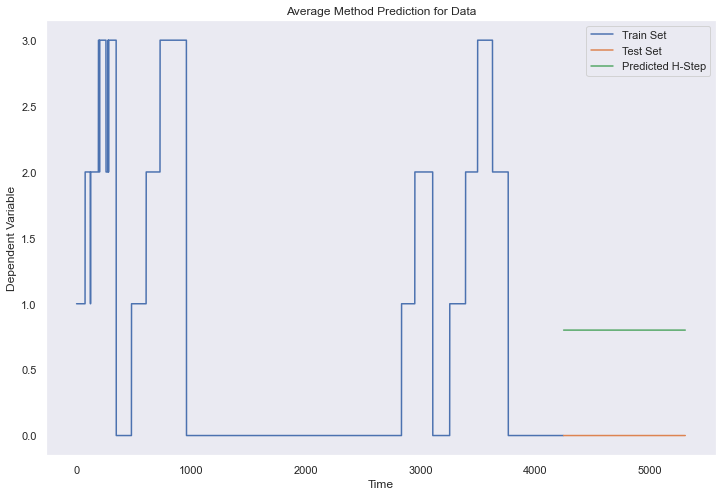

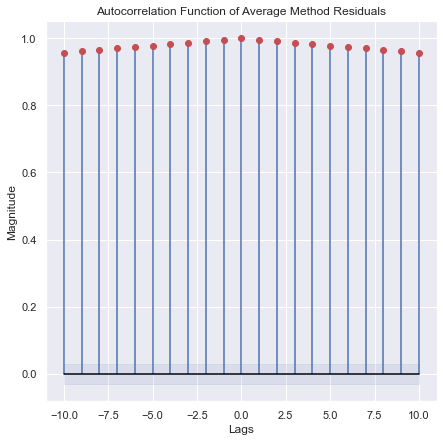

           MSE  Variance  Q via Box-Pierce
Residual  1.18       1.1          20617.16
Forecast  0.60       0.0               NaN

Naive Method


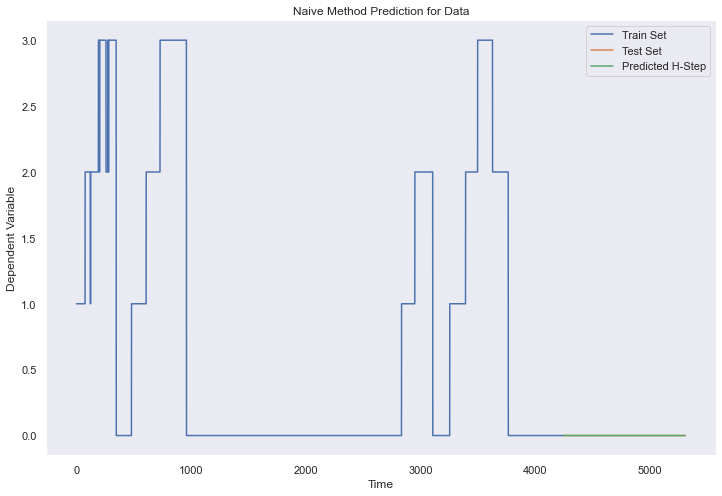

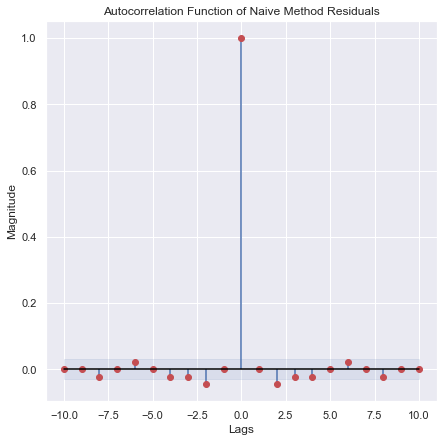

           MSE  Variance  Q via Box-Pierce
Residual  0.01       0.0             12.57
Forecast  0.00       0.0               NaN

Drift Method


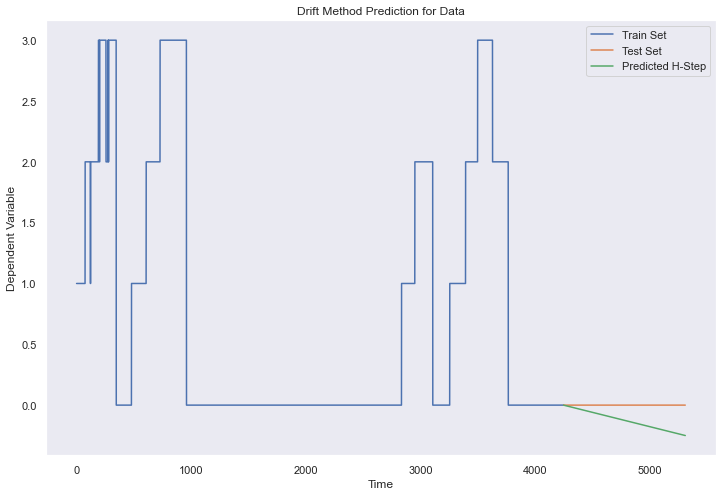

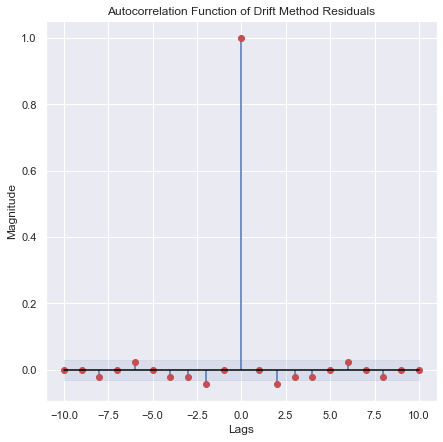

           MSE  Variance  Q via Box-Pierce
Residual  0.01       0.0             12.57
Forecast  0.00       0.0               NaN


,Q via Box-Pierce,MSE - Residual,MSE - Forecast,Variance - Residual
Average,20617.16,1.18,0.6,0.0
Naive,12.57,0.01,0.0,0.0
Drift,12.57,0.01,0.0,0.0


In [9]:
## Base Models - Average, Naive, Drift
method =["Average", "Naive", "Drift"]
results = []
for i in method:
    print("\n============================================")
    print(f"{i} Method")
    dfTrain, dfTest = getMethodDF(list(dfY_train.Room_Occupancy_Count.values), list(dfY_test.Room_Occupancy_Count.values), offsetDF=1, method=i)
    Q = sm.stats.acorr_ljungbox(dfTrain.error[2:], lags=[5], boxpierce=True, return_df=True)
    mseDF = pd.DataFrame({"MSE":[getMSE(list(dfTrain.errorSq),offset=2),getMSE(list(dfTest.errorSq),offset=0)],
                         "Variance":[round(statistics.variance(list(dfTrain.error[2:])),1),round(statistics.variance(list(dfTest.error)),1)],
                         "Q via Box-Pierce":[round(Q.bp_stat.iloc[0],2),None]},index=["Residual", "Forecast"])
    getGraph(dfTrain,dfTest, name=i)
    getACFAll(list(dfTrain.error[1:]), timeLagMax=10, title=f"{i} Method Residuals", plot = True)
    plt.show()
    print(mseDF)
    results.append(mseDF)

results = pd.DataFrame({"Q via Box-Pierce":[x["Q via Box-Pierce"].iloc[0] for x in results],
             "MSE - Residual":[x.MSE.iloc[0] for x in results],
             "MSE - Forecast":[x.MSE.iloc[1] for x in results],
             "Variance - Residual":[x.Variance.iloc[1] for x in results]},
            index=method)
results

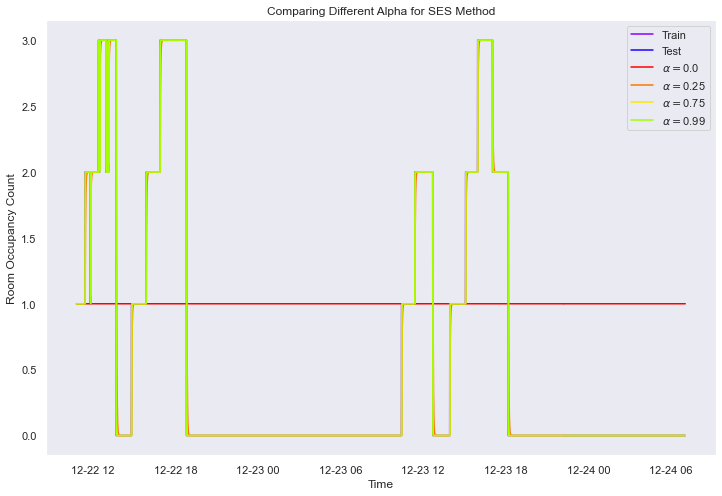

In [10]:
## Base Models - Exponential Smoothing w/ different alphas
c = plt.cm.get_cmap("hsv", 14)
plt.figure(figsize=(12, 8))
plt.plot(dfY_train.index, dfY_train.Room_Occupancy_Count, color=c(10), label="Train")
plt.plot(dfY_test.index, dfY_test.Room_Occupancy_Count, color=c(9), label="Test")
alpha= [0.0,0.25,0.75,0.99]
for idx in range(len(alpha)):
    sse = SimpleExpSmoothing(dfY_train.Room_Occupancy_Count.values, initialization_method="known", initial_level=dfY_train.Room_Occupancy_Count[0]).fit(
        smoothing_level=alpha[idx], optimized=False)
    plt.plot(dfY_train.index, sse.fittedvalues, color=c(idx))
    plt.plot(dfY_test.index, sse.forecast(len(dfY_test)), color=c(idx),label=r"$\alpha=$"+str(alpha[idx]))
plt.xlabel("Time")
plt.ylabel("Room Occupancy Count")
plt.title("Comparing Different Alpha for SES Method")
plt.grid()
plt.legend()
plt.show()

In [11]:
## Feature Selection / Elimination

## SVD
X_train_np = np.c_[np.ones(len(X_train)),X_train.iloc[:,1:].to_numpy()]
s, d, v = np.linalg.svd(X_train_np)
colinearityViaSVD = np.where(d<=0.5)[0]
print("SVD Results")
print(f"Via SVD with a threshold of <= 0.5 the following fields exhibit colinearity: {', '.join(list(X_train.columns[colinearityViaSVD]))}")

## BackwardsStepwise Regression
def backward_stepwise_regression(X, y, criteria='aic'):
    p = X.shape[1]
    selected_features = np.arange(p)
    model = sm.OLS(y, X).fit()
    if criteria == 'aic':
        best_criteria_value = model.aic
    elif criteria == 'bic':
        best_criteria_value = model.bic
    else:
        best_criteria_value = -model.rsquared_adj
    for _ in range(p):
        best_feature_to_remove = None
        for feature_to_remove in selected_features:
            remaining_features = np.setdiff1d(selected_features, feature_to_remove)
            remaining_X = X[:, remaining_features]
            remaining_model = sm.OLS(y, remaining_X).fit()
            if criteria == 'aic':
                criterion_value = remaining_model.aic
            elif criteria == 'bic':
                criterion_value = remaining_model.bic
            else:
                criterion_value = -remaining_model.rsquared_adj
            if criterion_value < best_criteria_value:
                best_criteria_value = criterion_value
                best_feature_to_remove = feature_to_remove
        selected_features = np.setdiff1d(selected_features, best_feature_to_remove)
        selected_X = X[:, selected_features]
    return selected_features

selectedFeatures_BIC = backward_stepwise_regression(X_train.values, y_train.values, criteria='bic')
selectedFeatures_AIC = backward_stepwise_regression(X_train.values, y_train.values, criteria='aic')
selectedFeatures_R2Adj = backward_stepwise_regression(X_train.values, y_train.values, criteria='rsquared_adj')
print("\nBackwards Stepwise Regression Results")
print(f"\nSelected features via Backwards Stepwise Regression w/ BIC as Evaluation: {', '.join(list(X_train.columns[selectedFeatures_BIC]))}")
print(f"\nSelected features via Backwards Stepwise Regression w/ AIC as Evaluation: {', '.join(list(X_train.columns[selectedFeatures_AIC]))}")
print(f"\nSelected features via Backwards Stepwise Regression w/ R2Adjusted as Evaluation: {', '.join(list(X_train.columns[selectedFeatures_R2Adj]))}")
selectedFeatures =  list(set(selectedFeatures_BIC)&set(selectedFeatures_AIC)&set(selectedFeatures_R2Adj))
selectedFeatures_Dropped = list(set(range(X_train.values.shape[1])) - set(selectedFeatures))
print(f"\nOverlap amongst all: {', '.join(list(X_train.columns[selectedFeatures]))}")
print(f"\nDropped Features: {', '.join(list(X_train.columns[selectedFeatures_Dropped]))}")

SVD Results
Via SVD with a threshold of <= 0.5 the following fields exhibit colinearity: S7_PIR

Backwards Stepwise Regression Results

Selected features via Backwards Stepwise Regression w/ BIC as Evaluation: S2_Temp, S3_Temp, S1_Light, S2_Light, S3_Light, S4_Light, S2_Sound, S3_Sound, S4_Sound, S5_CO2, S5_CO2_Slope, S6_PIR

Selected features via Backwards Stepwise Regression w/ AIC as Evaluation: S2_Temp, S3_Temp, S4_Temp, S1_Light, S2_Light, S3_Light, S4_Light, S2_Sound, S3_Sound, S4_Sound, S5_CO2, S5_CO2_Slope, S6_PIR, S7_PIR

Selected features via Backwards Stepwise Regression w/ R2Adjusted as Evaluation: S2_Temp, S3_Temp, S4_Temp, S1_Light, S2_Light, S3_Light, S4_Light, S2_Sound, S3_Sound, S4_Sound, S5_CO2, S5_CO2_Slope, S6_PIR, S7_PIR

Overlap amongst all: S2_Temp, S3_Temp, S1_Light, S2_Light, S3_Light, S4_Light, S2_Sound, S3_Sound, S4_Sound, S5_CO2, S5_CO2_Slope, S6_PIR

Dropped Features: S1_Temp, S1_Sound, S4_Temp, S7_PIR


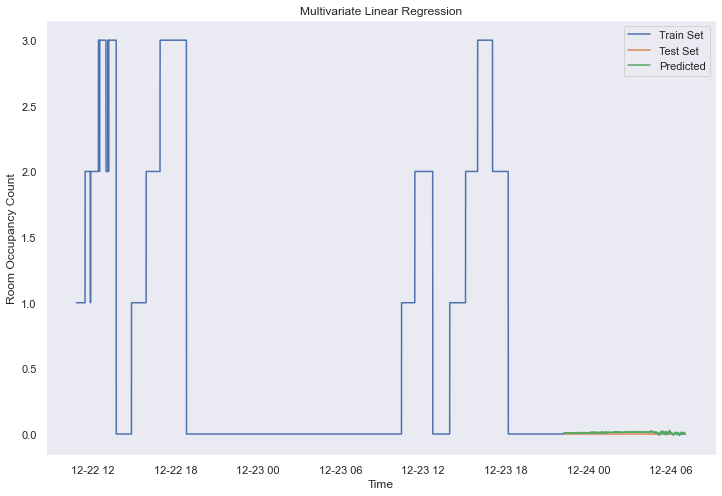

                             OLS Regression Results                             
Dep. Variable:     Room_Occupancy_Count   R-squared:                       0.992
Model:                              OLS   Adj. R-squared:                  0.992
Method:                   Least Squares   F-statistic:                 4.437e+04
Date:                  Fri, 12 May 2023   Prob (F-statistic):               0.00
Time:                          07:58:01   Log-Likelihood:                 3894.0
No. Observations:                  4244   AIC:                            -7762.
Df Residuals:                      4231   BIC:                            -7679.
Df Model:                            12                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2871      0.181

In [12]:
## Multiple Linear Regression
linearReg = sm.OLS(y_train,sm.add_constant(X_train.iloc[:,selectedFeatures].values)).fit()

fig = plt.figure(figsize=(12,8))
plt.plot(X_train.index, y_train, label="Train Set")
plt.plot(X_test.index, y_test, label="Test Set")
plt.plot(X_test.index, linearReg.predict(sm.add_constant(X_test.iloc[:,selectedFeatures].values)),label="Predicted")
plt.xlabel("Time")
plt.ylabel("Room Occupancy Count")
plt.title("Multivariate Linear Regression")
plt.grid()
plt.legend()
plt.show()


## Summary Report
print(linearReg.summary())

## One-step ahead prediction on test set
X_test_ = sm.add_constant(X_test.iloc[:,selectedFeatures].values)
y_pred = linearReg.predict(sm.add_constant(X_test_))


# Calculate evaluation metrics
n = len(y_test)
k = X_test_.shape[1] - 1 
resid = y_test.values - y_pred
rmse = np.sqrt(np.sum((resid)** 2) / (n - k - 1))
aic, bic, rsquared, rsquared_adj= linearReg.aic, linearReg.bic, linearReg.rsquared, linearReg.rsquared_adj

print("\nEvaluation Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"R-squared: {rsquared:.4f}")
print(f"Adjusted R-squared: {rsquared_adj:.4f}")
print(f"AIC: {aic:.4f}")
print(f"BIC: {bic:.4f}")


## Hypothesis tests
f_stat = linearReg.fvalue
f_pval = linearReg.f_pvalue
t_stat = linearReg.tvalues
t_pval = linearReg.pvalues
print("\nHypothesis Tests:")
print(f"F-statistic: {f_stat:.4f}")
print(f"F p-value: {f_pval:.4f}")
for i in range(1, k+1):
    print(f"t({i}): {t_stat[i]:.4f}, p-value: {t_pval[i]:.4f}")


# Calculate ACF of residuals and Q-value
acf = sm.tsa.stattools.acf(resid, nlags=10, qstat=True, fft=True)
q_value = acf[2][-1]
print("\nACF of Residuals:")
print(acf[0])
print("\nQ-value:")
print(f"Q-value: {q_value:.4f}")

# Calculate variance and mean of residuals
resid_var = np.var(resid)
resid_mean = np.mean(resid)
print("\nResiduals:")
print(f"Residual Variance: {resid_var:.4f}")
print(f"Residual Mean: {resid_mean:.4f}")

/Users/samueljon/opt/anaconda3/envs/cs5525/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


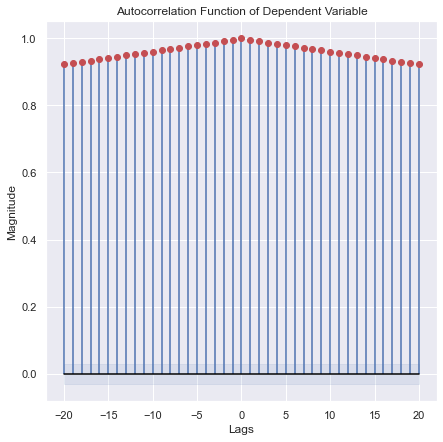

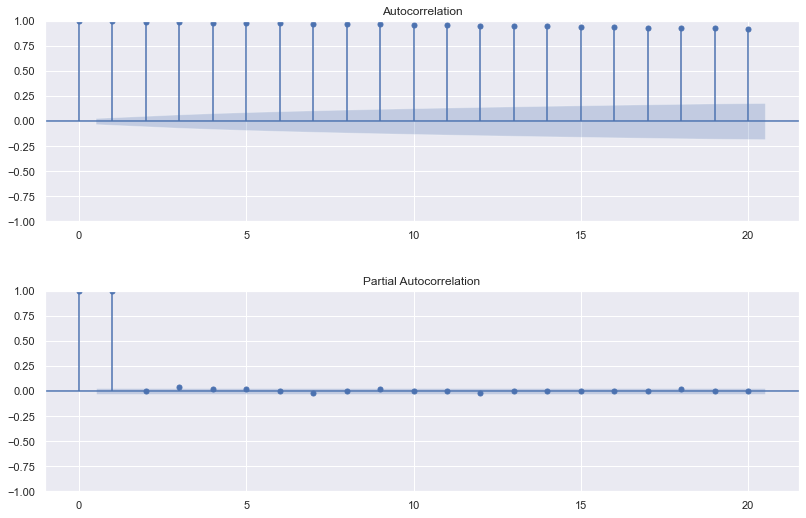

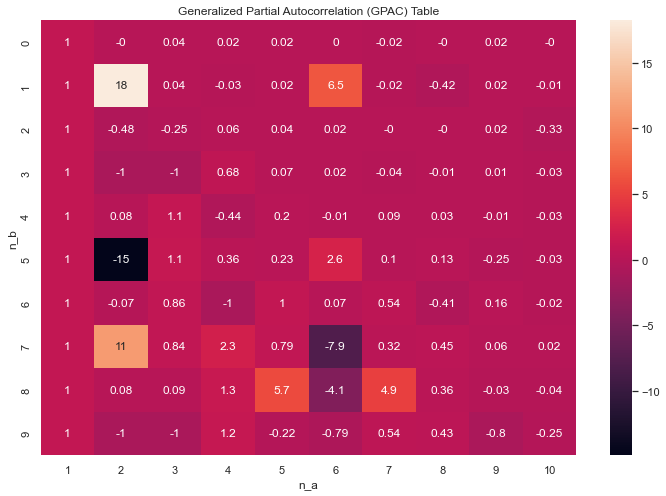

,1,2,3,4,5,6,7,8,9,10
0,1.0,-0.00,0.04,0.02,0.02,0.00,-0.02,-0.00,0.02,-0.00
1,1.0,18.23,0.04,-0.03,0.02,6.48,-0.02,-0.42,0.02,-0.01
2,1.0,-0.48,-0.25,0.06,0.04,0.02,-0.00,-0.00,0.02,-0.33
3,1.0,-1.00,-1.00,0.68,0.07,0.02,-0.04,-0.01,0.01,-0.03
4,1.0,0.08,1.08,-0.44,0.20,-0.01,0.09,0.03,-0.01,-0.03
5,1.0,-14.90,1.15,0.36,0.23,2.64,0.10,0.13,-0.25,-0.03
6,1.0,-0.07,0.86,-1.00,1.00,0.07,0.54,-0.41,0.16,-0.02
7,1.0,11.44,0.84,2.27,0.79,-7.94,0.32,0.45,0.06,0.02
8,1.0,0.08,0.09,1.32,5.71,-4.10,4.91,0.36,-0.03,-0.04
9,1.0,-1.00,-1.00,1.16,-0.22,-0.79,0.54,0.43,-0.80,-0.25


In [13]:
## ARMA, ARIMA, SARIMA -- GPAC
yTrain_acf = sm.tsa.acf(y_train.values, nlags=20)
# use one or the other for ACF
_, a = getACFAll(y_train.values, timeLagMax=20, title="Dependent Variable", plot = True, soloPlot=True)
# pacf
ACF_PACF_Plot(y_train.values,20)
getGPAC(yTrain_acf, maxJ=10, maxK=10, plot=True)

Predicted AR Order: [-0.9969]
Predicted MA Order: []


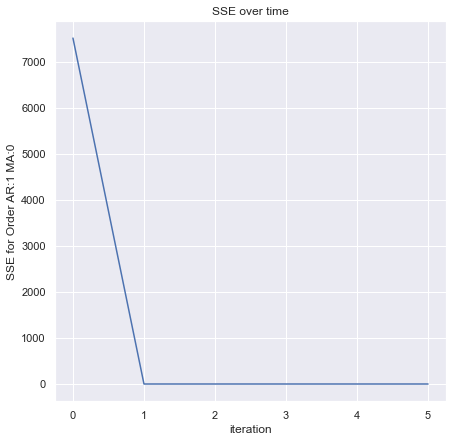

Statsmodel AR Parameters: [1.0]
Statsmodel MA Parameters: []
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4244
Model:                 ARIMA(1, 0, 0)   Log Likelihood                3628.160
Date:                Fri, 12 May 2023   AIC                          -7250.320
Time:                        07:58:06   BIC                          -7231.260
Sample:                             0   HQIC                         -7243.584
                               - 4244                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7653      0.696      1.100      0.271      -0.598       2.129
ar.L1          0.9956      0.003    380.822      0.000       0.990    

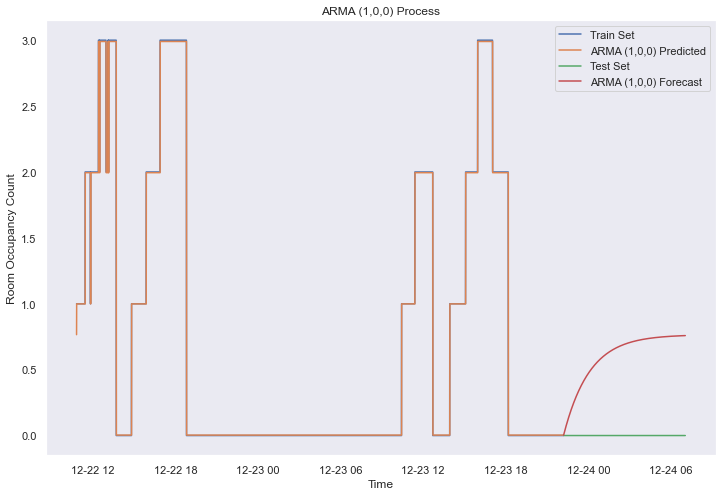

In [14]:
## ARMA Model Parameters -- LMA

## ARMA - AR:1, Diff:0, MA:0

AR = 1
Diff = 0
MA =0 

params, _, _, SSE_graph, _ = arma_lma(y_train.values.reshape(-1, 1), AR, MA, delta=1e-6, max_iter=100, 
         tol=1e-3, lambda_init=1e-2, lambda_factor=10, lambda_max = 1e9)

print(f"Predicted AR Order: {[round(i,4) for i in params[:AR]]}")
print(f"Predicted MA Order: {[round(i,4) for i in params[AR:]]}")

fig = plt.figure(figsize=(7,7))
plt.plot(list(range(len(SSE_graph))), SSE_graph)
plt.title("SSE over time")
plt.xlabel("iteration")
plt.ylabel("SSE for Order AR:1 MA:0")
plt.show()

ARMA = ARIMA(y_train.values, order=(AR, Diff, MA)).fit()
print(f"Statsmodel AR Parameters: {[round(i,2) for i in ARMA.arparams]}") 
print(f"Statsmodel MA Parameters: {[round(i,2) for i in ARMA.maparams]}") 
print(ARMA.summary())

fig = plt.figure(figsize=(12,8))
plt.plot(X_train.index, y_train, label="Train Set")
plt.plot(X_train.index, ARMA.predict(start=0, end=len(y_train)-1),label="ARMA (1,0,0) Predicted")
plt.plot(X_test.index, y_test, label="Test Set")
plt.plot(X_test.index, ARMA.forecast(steps=len(y_test)) ,label="ARMA (1,0,0) Forecast")
plt.xlabel("Time")
plt.ylabel("Room Occupancy Count")
plt.title("ARMA (1,0,0) Process")
plt.grid()
plt.legend()
plt.show()

Predicted AR Order: [-0.9972, 0.0431, -0.0226, 0.0019, -0.0224]
Predicted MA Order: []


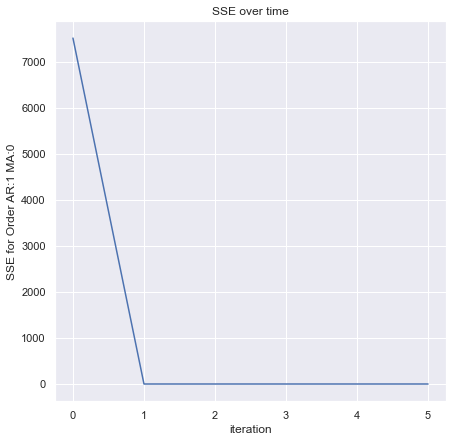

Statsmodel AR Parameters: [1.0, -0.04, 0.02, -0.0, 0.02]
Statsmodel MA Parameters: []
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4244
Model:                 ARIMA(5, 0, 0)   Log Likelihood                3633.896
Date:                Fri, 12 May 2023   AIC                          -7253.791
Time:                        07:58:08   BIC                          -7209.319
Sample:                             0   HQIC                         -7238.074
                               - 4244                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7653      0.762      1.005      0.315      -0.727       2.258
ar.L1          0.9966      0.311      3.201  

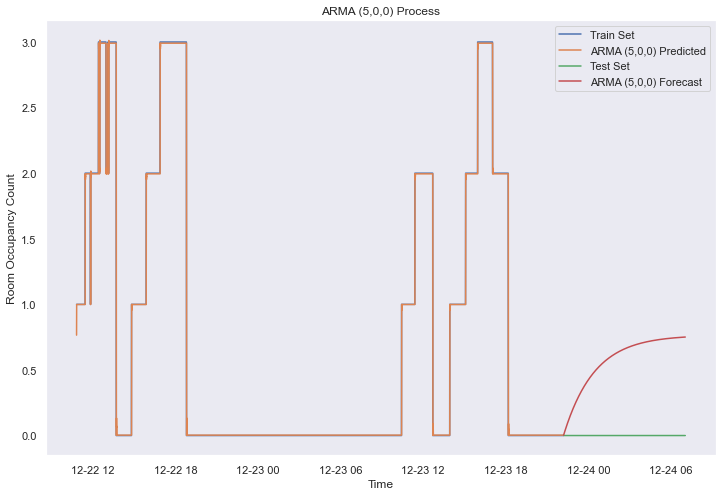

In [15]:
## ARMA - AR:5, Diff:0, MA:0

AR = 5
Diff = 0
MA =0 

params, _, _, SSE_graph, _ = arma_lma(y_train.values.reshape(-1, 1), AR, MA, delta=1e-6, max_iter=100, 
         tol=1e-3, lambda_init=1e-2, lambda_factor=10, lambda_max = 1e9)

print(f"Predicted AR Order: {[round(i,4) for i in params[:AR]]}")
print(f"Predicted MA Order: {[round(i,4) for i in params[AR:]]}")

fig = plt.figure(figsize=(7,7))
plt.plot(list(range(len(SSE_graph))), SSE_graph)
plt.title("SSE over time")
plt.xlabel("iteration")
plt.ylabel("SSE for Order AR:1 MA:0")
plt.show()

ARMA = ARIMA(y_train.values, order=(AR, Diff, MA)).fit()
print(f"Statsmodel AR Parameters: {[round(i,2) for i in ARMA.arparams]}") 
print(f"Statsmodel MA Parameters: {[round(i,2) for i in ARMA.maparams]}") 
print(ARMA.summary())

fig = plt.figure(figsize=(12,8))
plt.plot(X_train.index, y_train, label="Train Set")
plt.plot(X_train.index, ARMA.predict(start=0, end=len(y_train)-1),label="ARMA (5,0,0) Predicted")
plt.plot(X_test.index, y_test, label="Test Set")
plt.plot(X_test.index, ARMA.forecast(steps=len(y_test)) ,label="ARMA (5,0,0) Forecast")
plt.xlabel("Time")
plt.ylabel("Room Occupancy Count")
plt.title("ARMA (5,0,0) Process")
plt.grid()
plt.legend()
plt.show()

In [613]:
## EXTRA: Create a method that iterates through different AR, MA, Diff orders and compares AIC, BIC and pValues?


Confidence intervals:
 [[-0.59834028  2.12897125]
 [ 0.99045538  1.00070321]
 [ 0.01051948  0.01063924]]

Zero/pole cancellation:
 [0.99557929]
No root cancellation, only AR process

Chi-square test:
Test statistic: l
P-value: l

Residuals:
Residual Variance: 0.0106
Residual Mean: -0.0002

Foreacst:
Foreacst Variance: 0.0361
Foreacst Mean: -0.6043


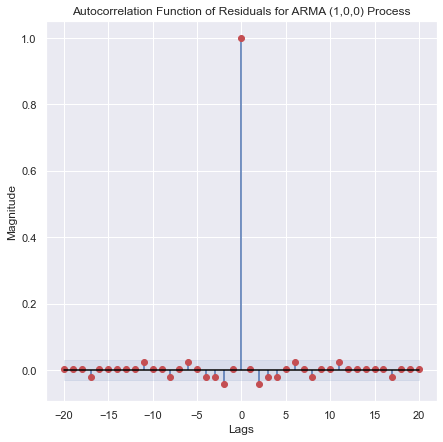

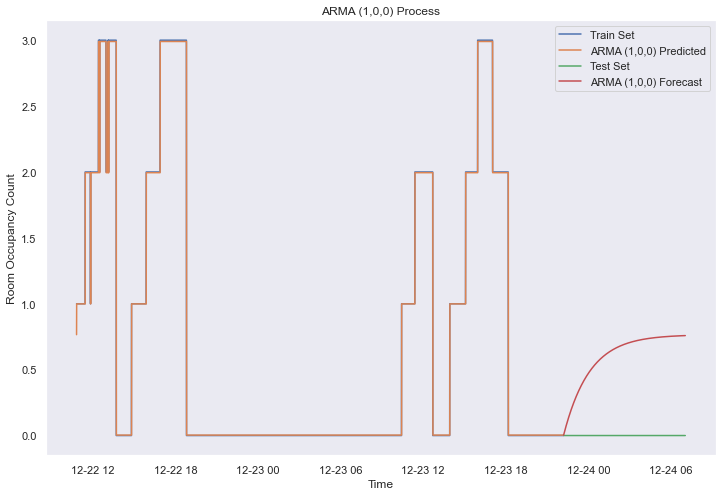

In [19]:
## Diagnostic Analysis 

ARMA = ARIMA(y_train.values, order=(1, 0, 0)).fit()
y_pred = ARMA.predict(start=0, end=len(y_train)-1)

# Confidence Interval
print("\nConfidence intervals:\n", ARMA.conf_int())

# Zero/Pole cancellation
print("\nZero/pole cancellation:\n", np.roots(np.r_[1, -ARMA.arparams]))
print("No root cancellation, only AR process")

# Calculate and display chi-square test
resid = y_train.values - y_pred
chi2, p_value = sm.stats.acorr_ljungbox(resid, lags=[len(ARMA.arparams)])
print("\nChi-square test:")
print("Test statistic:", chi2[0])
print("P-value:", p_value[0])

# Calculate variance and mean of residuals
resid_var = np.var(resid)
resid_mean = np.mean(resid)
print("\nResiduals:")
print(f"Residual Variance: {resid_var:.4f}")
print(f"Residual Mean: {resid_mean:.4f}")

# Calculate variance and mean of forecast
forecast = y_test.values - ARMA.forecast(steps=len(y_test))
forecast_var = np.var(forecast)
forecast_mean = np.mean(forecast)
print("\nForeacst:")
print(f"Foreacst Variance: {forecast_var:.4f}")
print(f"Foreacst Mean: {forecast_mean:.4f}")

## Show residuals are WN
_, _ = getACFAll(resid, timeLagMax=20, title="Residuals for ARMA (1,0,0) Process", plot = True, soloPlot=True)

fig = plt.figure(figsize=(12,8))
plt.plot(X_train.index, y_train, label="Train Set")
plt.plot(X_train.index, ARMA.predict(start=0, end=len(y_train)-1),label="ARMA (1,0,0) Predicted")
plt.plot(X_test.index, y_test, label="Test Set")
plt.plot(X_test.index, ARMA.forecast(steps=len(y_test)) ,label="ARMA (1,0,0) Forecast")
plt.xlabel("Time")
plt.ylabel("Room Occupancy Count")
plt.title("ARMA (1,0,0) Process")
plt.grid()
plt.legend()
plt.show()

In [23]:
sm.stats.acorr_ljungbox(resid, lags=10)

,lb_stat,lb_pvalue
1,0.021122,0.884448
2,7.539756,0.023055
3,9.228188,0.026406
4,10.918476,0.027496
5,10.938946,0.052604
6,13.456233,0.036337
7,13.476400,0.061317
8,15.173983,0.055849
9,15.193850,0.085747
10,15.213572,0.124467


Epoch 1/50
133/133 [==============================] - 1s 3ms/step - loss: 662.6196 - val_loss: 0.8359
Epoch 2/50
133/133 [==============================] - 0s 2ms/step - loss: 20.8437 - val_loss: 0.0190
Epoch 3/50
133/133 [==============================] - 0s 2ms/step - loss: 10.6542 - val_loss: 5.4256e-04
Epoch 4/50
133/133 [==============================] - 0s 2ms/step - loss: 6.1497 - val_loss: 4.5909e-04
Epoch 5/50
133/133 [==============================] - 0s 2ms/step - loss: 3.8768 - val_loss: 3.5330e-04
Epoch 6/50
133/133 [==============================] - 0s 2ms/step - loss: 2.5187 - val_loss: 2.3414e-04
Epoch 7/50
133/133 [==============================] - 0s 2ms/step - loss: 1.6806 - val_loss: 1.4184e-04
Epoch 8/50
133/133 [==============================] - 0s 2ms/step - loss: 1.2046 - val_loss: 7.1985e-05
Epoch 9/50
133/133 [==============================] - 0s 2ms/step - loss: 0.9571 - val_loss: 3.5619e-05
Epoch 10/50
133/133 [==============================] - 0s 2ms/step -

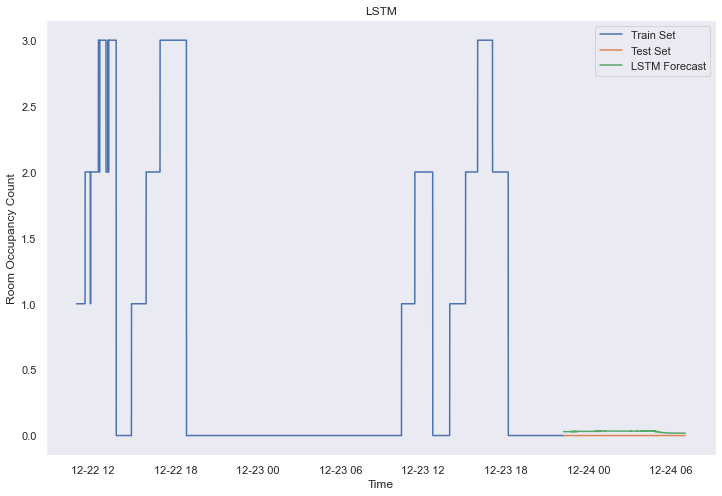

In [733]:
## Deep Learning Model -- LSTM

X_train_LSTM = np.reshape(X_train.values, (X_train.values.shape[0], 1, X_train.values.shape[1]))
X_test_LSTM = np.reshape(X_test.values, (X_test.values.shape[0], 1, X_test.values.shape[1]))


# define the model architecture
model = Sequential()
model.add(LSTM(units=32, activation='relu', input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')

# train the model with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train_LSTM, y_train.values, epochs=50, batch_size=32, validation_data=(X_test_LSTM, y_test.values), callbacks=[early_stop])

# make predictions on the test set
y_pred = model.predict(X_test_LSTM)

# calculate performance metrics (e.g. mean squared error)
mse = np.mean((y_test.values - y_pred)**2)
print('MSE:', mse)

# Residual and Forecast Variance and Meann
resid = y_train.values - model.predict(X_train_LSTM).squeeze()
resid_var = np.var(resid)
resid_mean = np.mean(resid)
print("\nResiduals:")
print(f"Residual Variance: {resid_var:.4f}")
print(f"Residual Mean: {resid_mean:.4f}")

forecast = y_test.values - model.predict(X_test_LSTM).squeeze()
forecast_var = np.var(forecast)
forecast_mean = np.mean(forecast)
print("\nForeacst:")
print(f"Foreacst Variance: {forecast_var:.4f}")
print(f"Foreacst Mean: {forecast_mean:.4f}")

## Show residuals are WN
# _, _ = getACFAll(resid, timeLagMax=20, title="Residuals for LSTM", plot = True, soloPlot=True)

## Plot train, test and predicted
fig = plt.figure(figsize=(12,8))
plt.plot(X_train.index, y_train, label="Train Set")
plt.plot(X_test.index, y_test, label="Test Set")
plt.plot(X_test.index, y_pred ,label="LSTM Forecast")
plt.xlabel("Time")
plt.ylabel("Room Occupancy Count")
plt.title("LSTM")
plt.grid()
plt.legend()
plt.show()

In [ ]:
## FINAL SELETED MODEL

## Forecast Function

## H-Step Prediciton
